## Layer by Layer training Model
March 4, 2025

In [1]:
import sys
import os

myhost = os.uname()[1]
print("Running on Computer: [%s]" %myhost)

sys.path.insert(0, '/home/ifernand/Code/') 
dirname = '/home/ifernand/Cloud_SynthData_Proj'

import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from scipy import io as sio
import torch
import time
import h5py

# NDN tools
import NDNT
import NDNT.utils as utils
from NDNT.modules.layers import *
from NDNT.networks import *
import NDNT.NDN as NDN
from NTdatasets.conway.synthcloud_datasets import SimCloudData
from NTdatasets.generic import GenericDataset
from ColorDataUtils.multidata_utils import MultiExperiment
import ColorDataUtils.ConwayUtils as CU
from ColorDataUtils import readout_fit
from ColorDataUtils.simproj_utils import *
from NDNT.utils import fit_lbfgs, fit_lbfgs_batch
from NDNT.utils import imagesc   
from NDNT.utils import ss
from NDNT.utils import subplot_setup
from NDNT.utils import figure_export

# Clustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device0 = torch.device("cpu")
dtype = torch.float32

%load_ext autoreload
%autoreload 2

Running on Computer: [sc]
Invoking __init__.py for NDNT.utils


## Load Data

In [2]:
start    = time.time()
data     = SimCloudData(cell_type_list=['V1_Exc_L4', 'V1_Inh_L4', 'V1_Exc_L2/3', 'V1_Inh_L2/3'], down_sample=2, num_lags=11)
end      = time.time()
print('CPU Time', end-start, 'sec')

CPU Time 53.648927450180054 sec


In [3]:
# Load baseline LL
GLM_LL = np.load('data/2-28_update_cloud_data_stim_dim_120_sqrad_0.3_GLM_LL.npy')
GQM_LL = np.load('data/2-28_update_cloud_data_stim_dim_120_sqrad_0.3_GQM_LL.npy')

In [4]:
# Load Complexity Index (calculated from GQM)
comp = np.load('data/2-28_update_all_neuron_complexity_sqrad_0.3.npy')

In [5]:
cell_idx_dict = data.cell_idx_dict
thetas_dict = data.thetas
V1_thetas = np.concatenate((thetas_dict['V1_Exc_L4'], thetas_dict['V1_Inh_L4'], thetas_dict['V1_Exc_L2/3'], thetas_dict['V1_Inh_L2/3']))

L4_exc_idx = cell_idx_dict['V1_Exc_L4']
L4_inh_idx = cell_idx_dict['V1_Inh_L4']
L23_exc_idx = cell_idx_dict['V1_Exc_L2/3']
L23_inh_idx = cell_idx_dict['V1_Inh_L2/3']

In [6]:
mu0s = data.mu0s
stim_dims = data.stim_dims
num_lags = data.num_lags
L  = stim_dims[1]
NC = data.NC
NT = data.NT
print('stim_dims =', stim_dims)
print('num_lags =', num_lags)
print('L =', L)
print('Number of cells', NC)
print('Number of time points', NT)

stim_dims = [1, 60, 60, 1]
num_lags = 11
L = 60
Number of cells 1491
Number of time points 510000


## Degree to Qum

In [7]:
def degrees2mu(theta_deg, angles, continuous=True, max_angle=180 ):
    """
    Converts degrees into mu-values. If to_output=True, outputs to an array, and otherwise
    stores in the Qmu variable. It detects whether half-circle of full circle using stored angle values
        
    Args:
        theta_deg (np array): array of angles in degrees into mu values, based on 180 or 360 deg wrap-around
        continuous (Boolean): whether to convert to continuous angle or closest "integer" mu value (def True, continuous)
        max_angle: maximum angle represented in OriConv layers (default 180, but could be 360)
    Returns:
        Qmus: as numpy-array, if to_output is set to True, otherwise, nothing 
    """
    num_angles = len(angles)

    # convert inputs to np.array
    if not isinstance(theta_deg, np.ndarray):
        theta_deg = np.array(theta_deg, dtype=np.float32)
    if not continuous:
        dQ = max_angle/num_angles
        theta_deg = dQ * np.round(theta_deg/dQ)
    theta_deg = (theta_deg%max_angle)  # map between 0 and max_angle

    mu_offset = 1/num_angles # first bin at 0 degrees is actually a shifted mu value (not right at edge)
    Qmus = (theta_deg-max_angle/2) / (max_angle/2) + mu_offset
    Qmus[Qmus <= -1] += 2
    Qmus[Qmus > 1] += -2
    
    return Qmus

In [8]:
angles = np.arange(0, 180, 30).astype(int)
Qmu0s = degrees2mu(V1_thetas, angles)
print('Angle mu0:', Qmu0s.shape)

Angle mu0: (1491,)


## Model for LGN Units

In [9]:
LGN_cnn = NDN.load_model('models/1016_three_layer_model_ORICONV_CNN_L4_None_maxreg.ndn')
LGN_cnn.block_sample = True
LGN_cnn.list_parameters()

Network 0:
  Layer 0:
      weight: torch.Size([3610, 2])
  Layer 1:
      weight: torch.Size([722, 12])
  Layer 2:
      NOT FIT: weight: torch.Size([1, 1])
  Layer 3:
      weight: torch.Size([300, 8])
Network 1:
  Layer 0:
      weight: torch.Size([20, 794])
      bias: torch.Size([794])
      mu: torch.Size([794, 2])
      sigma: torch.Size([794, 1])
      Qmu: torch.Size([794, 1])
      Qsigma: torch.Size([794, 1])


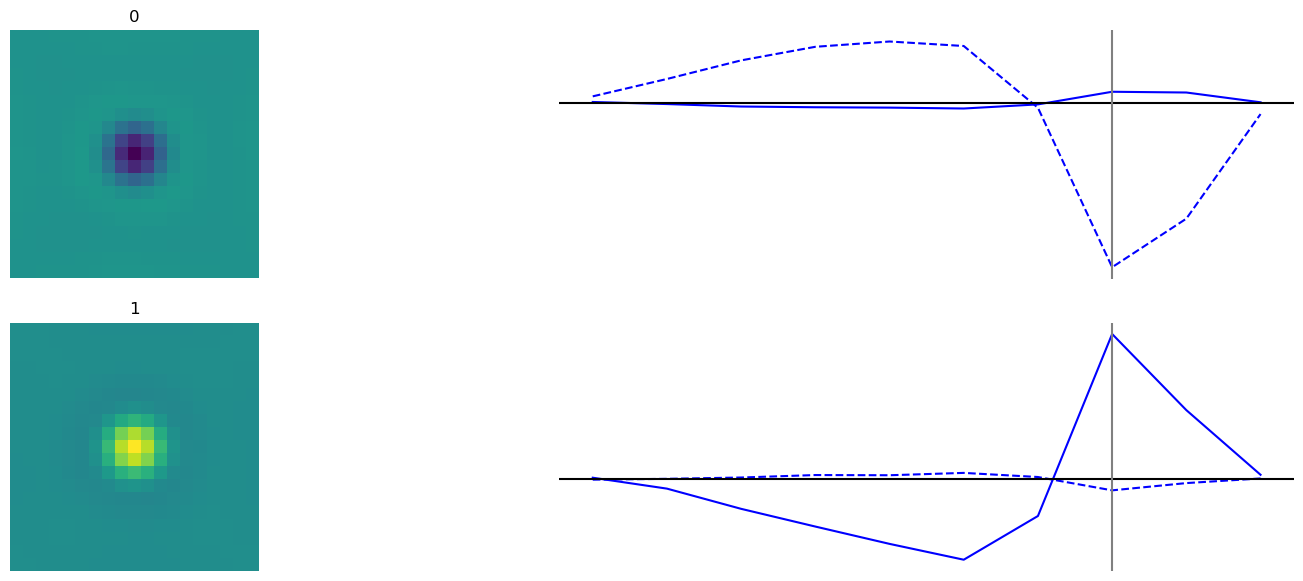

In [10]:
LGN_cnn.plot_filters()

## First Layer Train

In [11]:
# Adam Parameters
adam_pars = utils.create_optimizer_params(
    optimizer_type='AdamW', batch_size=1,
    learning_rate=0.01, early_stopping_patience=4,
    optimize_graph=False, weight_decay=0.2, accumulated_grad_batches=3)
adam_pars['device'] = device

In [62]:
XTreg = 0.0001
Xreg0 = 1.0 # d2/dx
Creg0 = 0.05 # center

Xreg1 = 0.003 # d2/dx
Creg1 = 0.0001 # center

MaxReg = 0.0001

angle_mode = 'nearest' # 'bilinear'

NQ = len(angles)

num_subs = [2, 16, 8, 8]
fws = [19, 19, 5, 5]

# LGN LAYER
clayersQ = [STconvLayer.layer_dict( 
    input_dims = data.stim_dims, num_filters=num_subs[0], norm_type=1,
    filter_dims=[1,fws[0],fws[0],num_lags-1] , bias=False, NLtype='relu',
    padding='circular', output_norm='batch', window='hamming', initialize_center=True,
    reg_vals={'d2xt':XTreg, 'd2x':Xreg0, 'center': Creg0} )]

# PROJECTION LAYER
clayersQ.append(
    OriConvLayer.layer_dict(
        num_filters=num_subs[1], num_inh=num_subs[1]//4,
        filter_width=fws[1], NLtype='relu', norm_type=1,
        bias=False, output_norm='batch', window='hamming', padding='circular', initialize_center=True, 
        reg_vals={'d2x':Xreg1, 'center': Creg1}, angles=angles) )

scaffold_netQ =  FFnetwork.ffnet_dict(
    ffnet_type='scaffold3d', xstim_n='stim', layer_list=clayersQ, scaffold_levels=[1], num_lags_out=NQ)

readout_parsQ = ReadoutLayerQsample.layer_dict(
    num_filters=NC, NLtype='softplus', bias=True, pos_constraint=True,
    reg_vals={'max': MaxReg})

readout_netQ = FFnetwork.ffnet_dict(xstim_n = None, ffnet_n=[0], layer_list = [readout_parsQ], ffnet_type='readout')

In [63]:
cnn1 = NDN(ffnet_list = [scaffold_netQ, readout_netQ], loss_type='poisson')
print(cnn1.info())
print(cnn1.list_parameters())

NDN poisson, output net #1:
  0 scaffold3d: Input = 'stim' [1, 60, 60, 1], Scaffold levels = 1
    0 STconv10:   2 (i0)  [relu] w19 NBH	{'d2xt': 0.0001, 'd2x': 1.0, 'center': 0.05}
    1  oriconv:  16 (i4)  [relu] w19 NBH	{'d2x': 0.003, 'center': 0.0001}
  1 readout: Input = ffnet 0 [16, 60, 60, 6]
    0 readQsmp: 1491 (i0)  [soft]  bias+	{'max': 0.0001}
None
Network 0:
  Layer 0:
      weight: torch.Size([3610, 2])
  Layer 1:
      weight: torch.Size([722, 16])
Network 1:
  Layer 0:
      weight: torch.Size([16, 1491])
      bias: torch.Size([1491])
      mu: torch.Size([1491, 2])
      sigma: torch.Size([1491, 1])
      Qmu: torch.Size([1491, 1])
      Qsigma: torch.Size([1491, 1])
None


In [64]:
# Network 0: fix LGN filters
cnn1.networks[0].layers[0].weight.data = deepcopy(LGN_cnn.networks[0].layers[0].weight.data)
cnn1.networks[0].layers[0].set_parameters(val=False)
# Network 1: set mu values
cnn1.networks[1].layers[0].mu.data = torch.tensor(mu0s, dtype=torch.float32)
cnn1.networks[1].layers[0].Qmu.data[:,0] = torch.tensor(Qmu0s, dtype=torch.float32)
cnn1.networks[1].layers[0].fit_mus(True)
cnn1.networks[1].layers[0].fit_Qmus(False)
cnn1.networks[1].layers[0].Qsample_mode = angle_mode
cnn1.block_sample = True

  ReadoutLayer: fitting mus
  ReadoutLayer: not fitting Qmus


In [65]:
cnn1.fit(data, **adam_pars, verbose=2)

Model: M491_CsX_X

GPU Available: True, GPU Used: True


Validating ver=22: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 102/102 [00:12<00:00,  8.39it/s, val_loss=0.305641]

Early stopping
Done fitting
  Fit complete: 1501.8991866111755 sec elapsed


In [66]:
LL1 = cnn1.eval_models(data, data_inds=data.val_blks, device=device, batch_size=1, null_adjusted=True)
print('Log Likelyhood shape', LL1.shape)

Eval models: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 102/102 [00:11<00:00,  8.65it/s]

Log Likelyhood shape (1491,)


In [67]:
print('L4 Exc Mean LL:', np.mean(LL1[L4_exc_idx]), 'L4 Inh Mean LL:', np.mean(LL1[L4_inh_idx]),
      'L2/3 Exc Mean LL:', np.mean(LL1[L23_exc_idx]), 'L2/3 Inh Mean LL:', np.mean(LL1[L23_inh_idx]))

L4 Exc Mean LL: 0.4098283 L4 Inh Mean LL: 0.4015507 L2/3 Exc Mean LL: 0.14180277 L2/3 Inh Mean LL: 0.04955935


Text(0.5, 1.0, 'Layer 2/3 Inh')

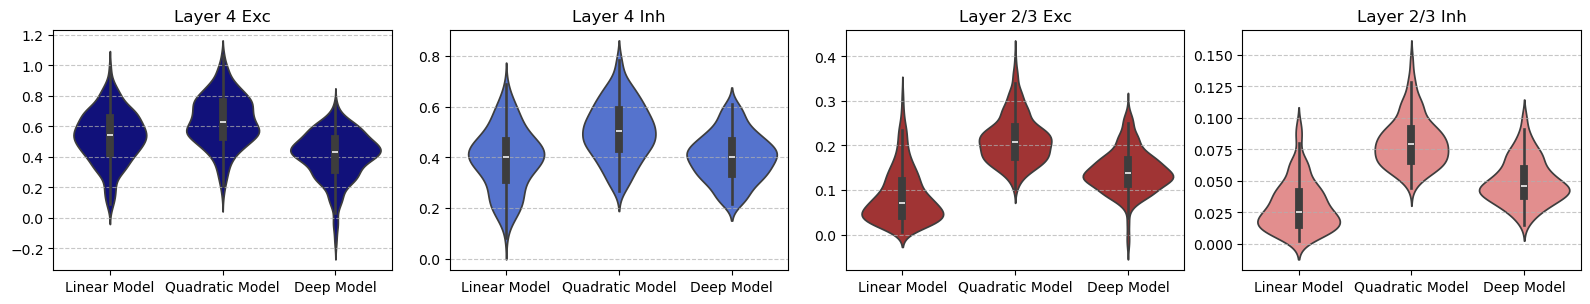

In [68]:
import seaborn as sns
colors = ['darkblue', 'royalblue', 'firebrick', 'lightcoral']
ss(1,4)
plt.subplot(1,4,1)
LL_to_plot = [GLM_LL[L4_exc_idx], GQM_LL[L4_exc_idx], LL1[L4_exc_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.violinplot(data=LL_to_plot, color=colors[0])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 4 Exc')

plt.subplot(1,4,2)
LL_to_plot = [GLM_LL[L4_inh_idx], GQM_LL[L4_inh_idx], LL1[L4_inh_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.violinplot(data=LL_to_plot, color=colors[1])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 4 Inh')

plt.subplot(1,4,3)
LL_to_plot = [GLM_LL[L23_exc_idx], GQM_LL[L23_exc_idx], LL1[L23_exc_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.violinplot(data=LL_to_plot, color=colors[2])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 2/3 Exc')

plt.subplot(1,4,4)
LL_to_plot = [GLM_LL[L23_inh_idx], GQM_LL[L23_inh_idx], LL1[L23_inh_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.violinplot(data=LL_to_plot, color=colors[3])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 2/3 Inh')

In [69]:
filters1 = cnn1.get_weights(ffnet_target=0,layer_target=1)
ei_mask_layer1 = deepcopy(cnn1.networks[0].layers[1]._ei_mask).detach().cpu().numpy()
print(filters1.shape)
print(ei_mask_layer1.shape)

(2, 19, 19, 16)
(96,)


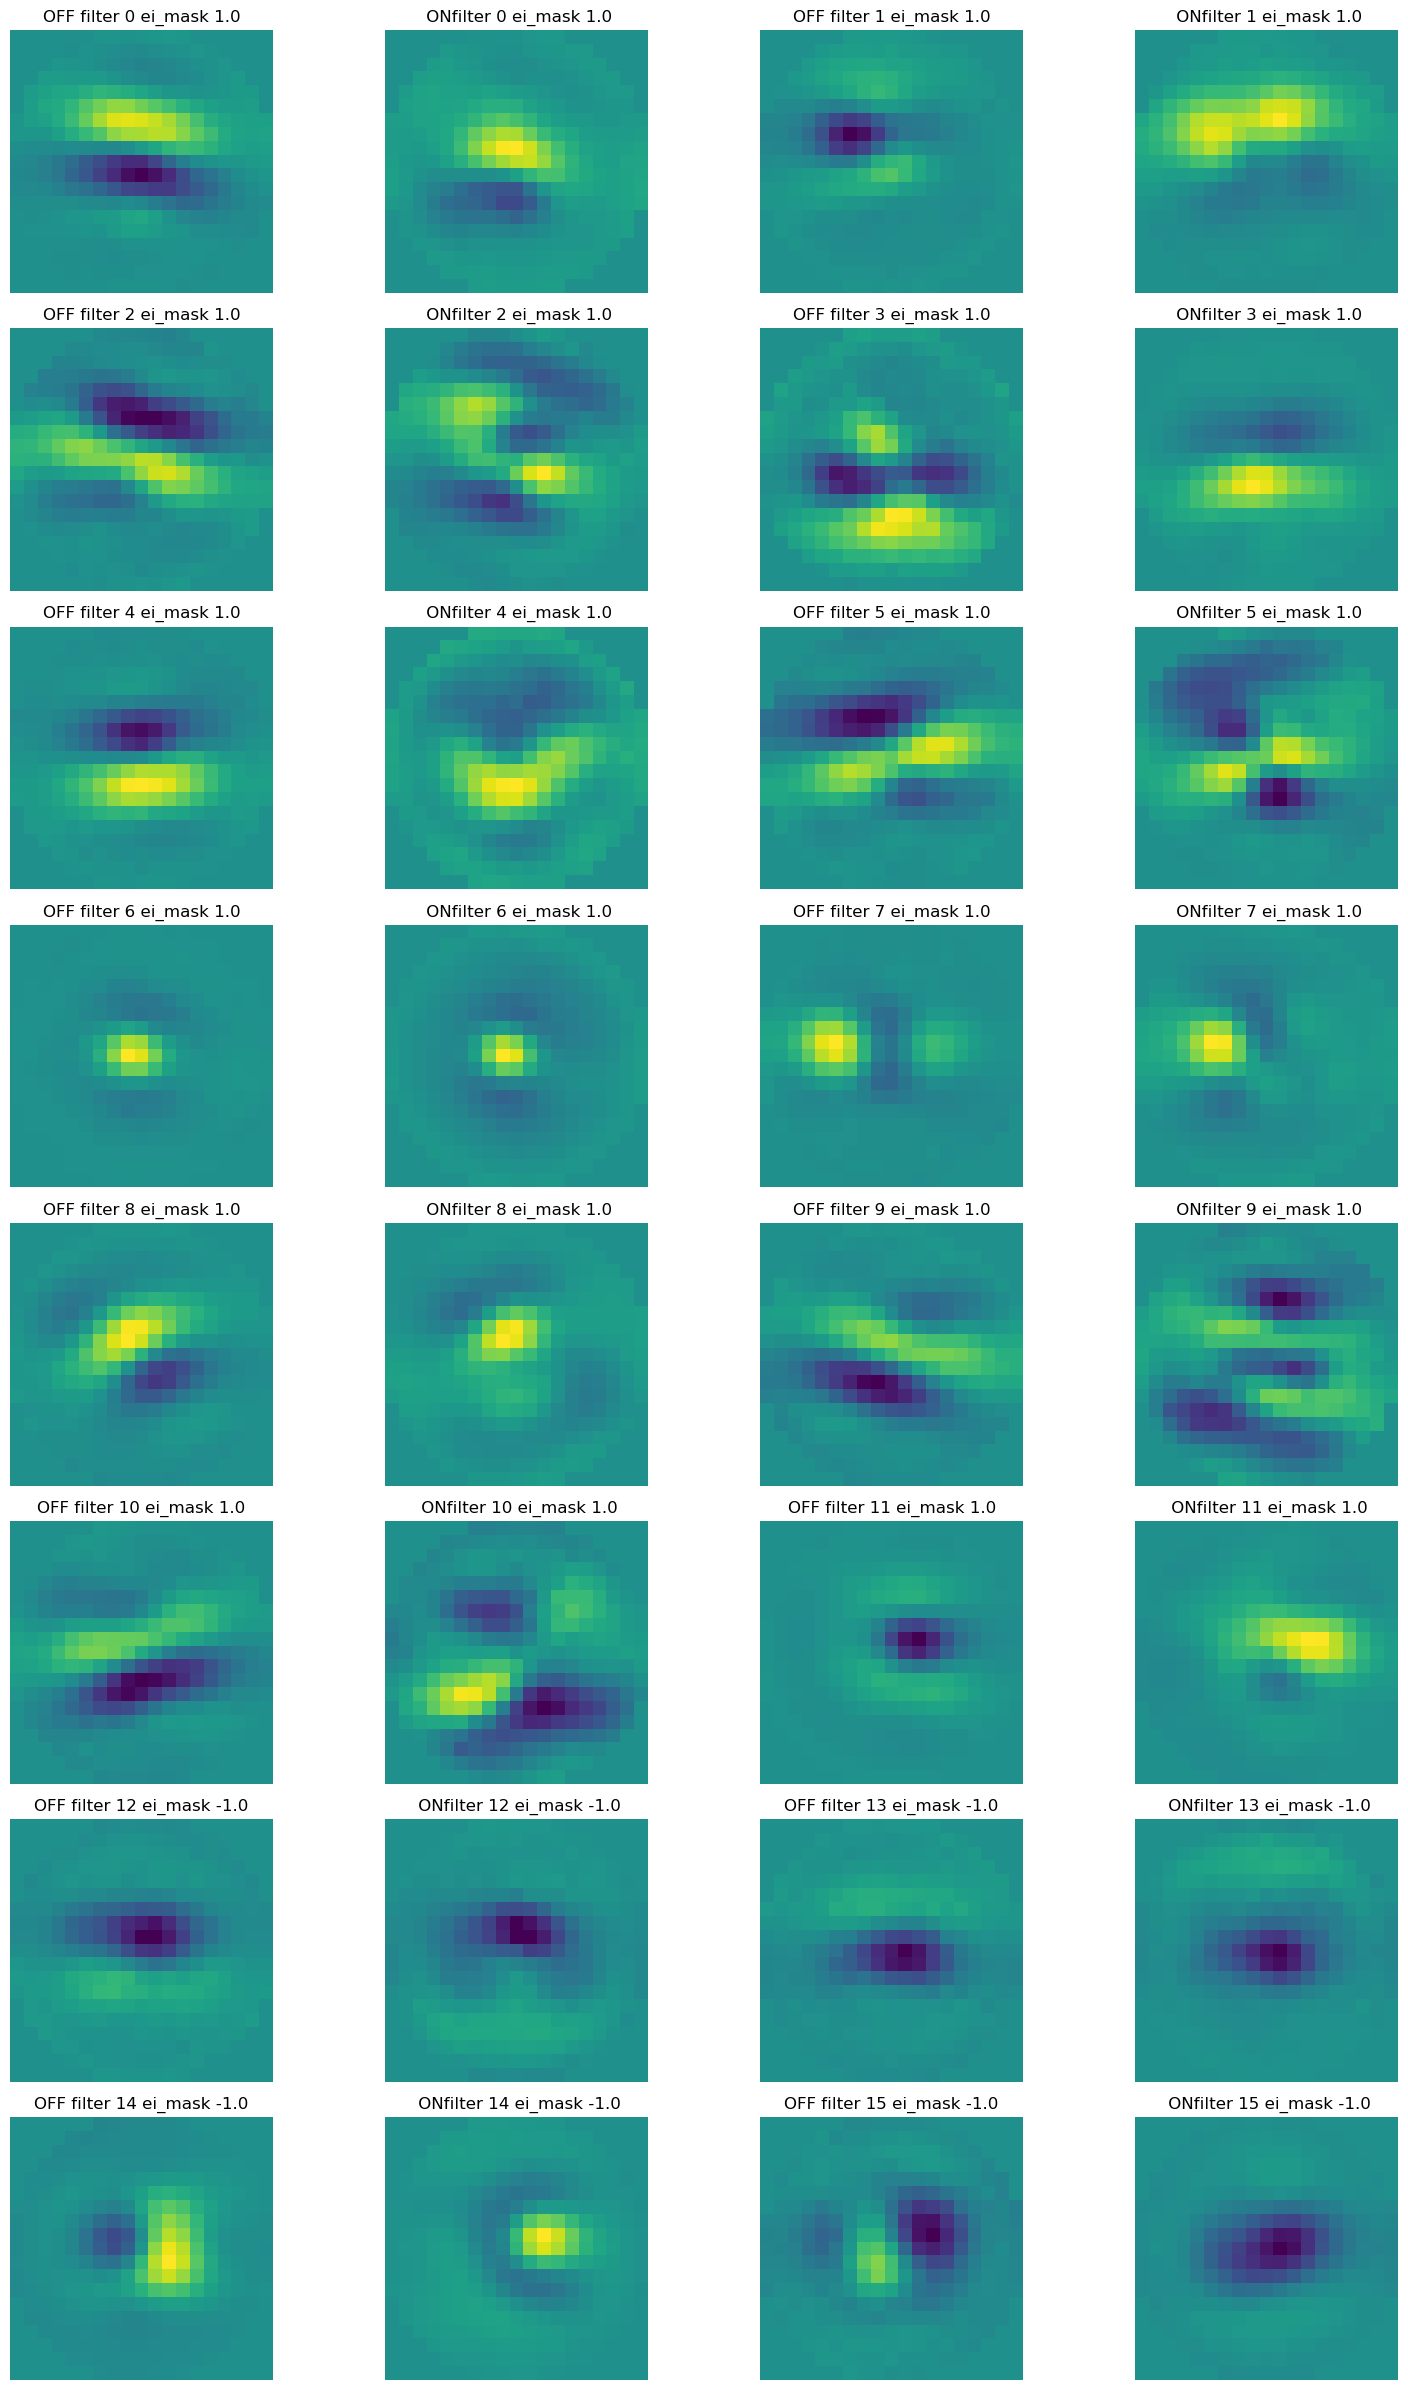

In [70]:
ss(8,4)
k = 1
for i in range(16):
    plt.subplot(8,4,k)
    imagesc(filters1[0,:,:,i], balanced=True)
    plt.title('OFF filter '+str(i)+' ei_mask '+str(ei_mask_layer1[i]))
    plt.axis('off')
    k += 1

    plt.subplot(8,4,k)
    imagesc(filters1[1,:,:,i], balanced=True)
    plt.title(' ONfilter '+str(i)+' ei_mask '+str(ei_mask_layer1[i]))
    plt.axis('off')
    k += 1
plt.tight_layout()
plt.show()

## Second Layer Train

In [71]:
# TIME SHIFT LAYER
clayersQ.append(TimeShiftLayer.layer_dict())

# SECOND LAYER
clayersQ.append(OriConvLayer.layer_dict( 
    num_filters=num_subs[2], num_inh=num_subs[2]//4, bias=False, norm_type=1, 
    filter_width=fws[2], NLtype='relu',
    output_norm='batch', initialize_center=True, #window='hamming', 
    angles=angles) )
        
scaffold_netQ =  FFnetwork.ffnet_dict(
    ffnet_type='scaffold3d', xstim_n='stim', layer_list=clayersQ, scaffold_levels=[1,3], num_lags_out=NQ)

readout_parsQ = ReadoutLayerQsample.layer_dict(
    num_filters=NC, NLtype='softplus', bias=True, pos_constraint=True,
    reg_vals={'max': MaxReg})

readout_netQ = FFnetwork.ffnet_dict(xstim_n = None, ffnet_n=[0], layer_list = [readout_parsQ], ffnet_type='readout')

In [72]:
cnn2 = NDN(ffnet_list = [scaffold_netQ, readout_netQ], loss_type='poisson')
print(cnn2.info())
print(cnn2.list_parameters())

NDN poisson, output net #1:
  0 scaffold3d: Input = 'stim' [1, 60, 60, 1], Scaffold levels = 1 3
    0 STconv10:   2 (i0)  [relu] w19 NBH	{'d2xt': 0.0001, 'd2x': 1.0, 'center': 0.05}
    1  oriconv:  16 (i4)  [relu] w19 NBH	{'d2x': 0.003, 'center': 0.0001}
    2   normal:   1 (i0)  [lin]   		
    3  oriconv:   8 (i2)  [relu] w5  NB		
  1 readout: Input = ffnet 0 [24, 60, 60, 6]
    0 readQsmp: 1491 (i0)  [soft]  bias+	{'max': 0.0001}
None
Network 0:
  Layer 0:
      weight: torch.Size([3610, 2])
  Layer 1:
      weight: torch.Size([722, 16])
  Layer 2:
      NOT FIT: weight: torch.Size([1, 1])
  Layer 3:
      weight: torch.Size([400, 8])
Network 1:
  Layer 0:
      weight: torch.Size([24, 1491])
      bias: torch.Size([1491])
      mu: torch.Size([1491, 2])
      sigma: torch.Size([1491, 1])
      Qmu: torch.Size([1491, 1])
      Qsigma: torch.Size([1491, 1])
None


In [73]:
# Network 0: fix LGN filters
cnn2.networks[0].layers[0].weight.data = deepcopy(LGN_cnn.networks[0].layers[0].weight.data)
cnn2.networks[0].layers[0].set_parameters(val=False)
# Network 0: fix projection filters
cnn2.networks[0].layers[1].weight.data = deepcopy(cnn1.networks[0].layers[1].weight.data)
cnn2.networks[0].layers[1].set_parameters(val=False)
# Network 1: set mu values
cnn2.networks[1].layers[0].mu.data = torch.tensor(mu0s, dtype=torch.float32)
cnn2.networks[1].layers[0].Qmu.data[:,0] = torch.tensor(Qmu0s, dtype=torch.float32)
cnn2.networks[1].layers[0].fit_mus(True)
cnn2.networks[1].layers[0].fit_Qmus(False)
cnn2.networks[1].layers[0].Qsample_mode = angle_mode
cnn2.block_sample = True

  ReadoutLayer: fitting mus
  ReadoutLayer: not fitting Qmus


In [74]:
cnn2.fit(data, **adam_pars, verbose=2)

Model: M491_CsXXX_X

GPU Available: True, GPU Used: True


Validating ver=51: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 102/102 [00:17<00:00,  5.87it/s, val_loss=0.28986]


Early stopping
Done fitting
  Fit complete: 3250.022463798523 sec elapsed


In [83]:
LL2 = cnn2.eval_models(data, data_inds=data.val_blks, device=device, batch_size=1, null_adjusted=True)
print('Log Likelyhood shape', LL2.shape)

Eval models: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 102/102 [00:16<00:00,  6.02it/s]

Log Likelyhood shape (1491,)


In [78]:
print('L4 Exc Mean LL:', np.mean(LL2[L4_exc_idx]), 'L4 Inh Mean LL:', np.mean(LL2[L4_inh_idx]),
      'L2/3 Exc Mean LL:', np.mean(LL2[L23_exc_idx]), 'L2/3 Inh Mean LL:', np.mean(LL2[L23_inh_idx]))

L4 Exc Mean LL: 0.6542089 L4 Inh Mean LL: 0.5299623 L2/3 Exc Mean LL: 0.269585 L2/3 Inh Mean LL: 0.10805542


Text(0.5, 1.0, 'Layer 2/3 Inh')

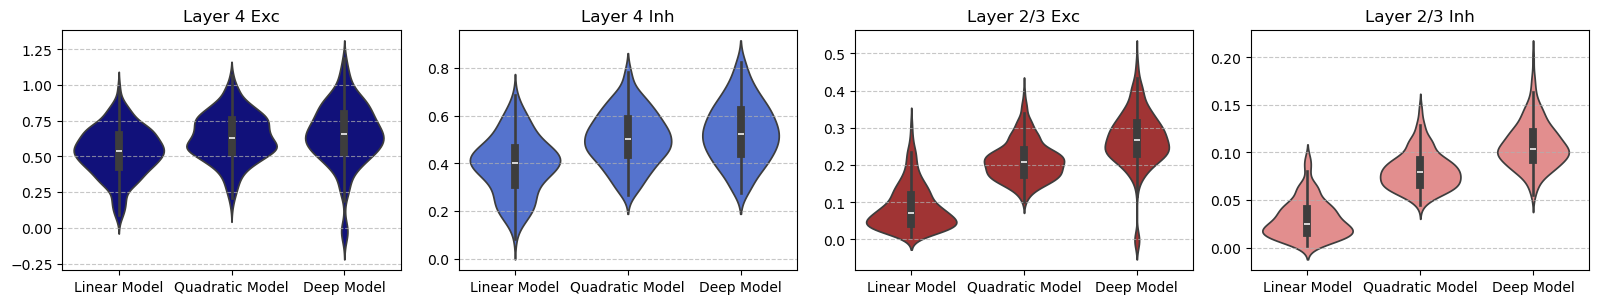

In [77]:
import seaborn as sns
colors = ['darkblue', 'royalblue', 'firebrick', 'lightcoral']
ss(1,4)
plt.subplot(1,4,1)
LL_to_plot = [GLM_LL[L4_exc_idx], GQM_LL[L4_exc_idx], LL2[L4_exc_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.violinplot(data=LL_to_plot, color=colors[0])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 4 Exc')

plt.subplot(1,4,2)
LL_to_plot = [GLM_LL[L4_inh_idx], GQM_LL[L4_inh_idx], LL2[L4_inh_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.violinplot(data=LL_to_plot, color=colors[1])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 4 Inh')

plt.subplot(1,4,3)
LL_to_plot = [GLM_LL[L23_exc_idx], GQM_LL[L23_exc_idx], LL2[L23_exc_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.violinplot(data=LL_to_plot, color=colors[2])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 2/3 Exc')

plt.subplot(1,4,4)
LL_to_plot = [GLM_LL[L23_inh_idx], GQM_LL[L23_inh_idx], LL2[L23_inh_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.violinplot(data=LL_to_plot, color=colors[3])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 2/3 Inh')

In [90]:
filters2 = cnn2.get_weights(ffnet_target=0,layer_target=3)
ei_mask_layer2 = deepcopy(cnn2.networks[0].layers[3]._ei_mask).detach().cpu().numpy()
print(filters2.shape)
print(ei_mask_layer2.shape)

(16, 5, 5, 8)
(48,)


## Third Layer Train

In [113]:
# THIRD LAYER
clayersQ.append(OriConvLayer.layer_dict( 
    num_filters=num_subs[3], num_inh=num_subs[3]//4, bias=False, norm_type=1, 
    filter_width=fws[3], NLtype='relu',
    output_norm='batch', initialize_center=True, #window='hamming', 
    angles=angles) )
        
scaffold_netQ =  FFnetwork.ffnet_dict(
    ffnet_type='scaffold3d', xstim_n='stim', layer_list=clayersQ, scaffold_levels=[1,3,4], num_lags_out=NQ)

readout_parsQ = ReadoutLayerQsample.layer_dict(
    num_filters=NC, NLtype='softplus', bias=True, pos_constraint=True,
    reg_vals={'max': MaxReg})

readout_netQ = FFnetwork.ffnet_dict(xstim_n = None, ffnet_n=[0], layer_list = [readout_parsQ], ffnet_type='readout')

In [114]:
cnn3 = NDN(ffnet_list = [scaffold_netQ, readout_netQ], loss_type='poisson')
print(cnn3.info())
print(cnn3.list_parameters())

NDN poisson, output net #1:
  0 scaffold3d: Input = 'stim' [1, 60, 60, 1], Scaffold levels = 1 3 4
    0 STconv10:   2 (i0)  [relu] w19 NBH	{'d2xt': 0.0001, 'd2x': 1.0, 'center': 0.05}
    1  oriconv:  16 (i4)  [relu] w19 NBH	{'d2x': 0.003, 'center': 0.0001}
    2   normal:   1 (i0)  [lin]   		
    3  oriconv:   8 (i2)  [relu] w5  NB		
    4  oriconv:   8 (i2)  [relu] w5  NB		
  1 readout: Input = ffnet 0 [32, 60, 60, 6]
    0 readQsmp: 1491 (i0)  [soft]  bias+	{'max': 0.0001}
None
Network 0:
  Layer 0:
      weight: torch.Size([3610, 2])
  Layer 1:
      weight: torch.Size([722, 16])
  Layer 2:
      NOT FIT: weight: torch.Size([1, 1])
  Layer 3:
      weight: torch.Size([400, 8])
  Layer 4:
      weight: torch.Size([200, 8])
Network 1:
  Layer 0:
      weight: torch.Size([32, 1491])
      bias: torch.Size([1491])
      mu: torch.Size([1491, 2])
      sigma: torch.Size([1491, 1])
      Qmu: torch.Size([1491, 1])
      Qsigma: torch.Size([1491, 1])
None


In [115]:
# Network 0: fix LGN filters
cnn3.networks[0].layers[0].weight.data = deepcopy(LGN_cnn.networks[0].layers[0].weight.data)
cnn3.networks[0].layers[0].set_parameters(val=False)
# Network 0: fix projection filters
cnn3.networks[0].layers[1].weight.data = deepcopy(cnn1.networks[0].layers[1].weight.data)
cnn3.networks[0].layers[1].set_parameters(val=False)
# Network 0: fix second filters
cnn3.networks[0].layers[3].weight.data = deepcopy(cnn2.networks[0].layers[3].weight.data)
cnn3.networks[0].layers[3].set_parameters(val=False)
# Network 1: set mu values
cnn3.networks[1].layers[0].mu.data = torch.tensor(mu0s, dtype=torch.float32)
cnn3.networks[1].layers[0].Qmu.data[:,0] = torch.tensor(Qmu0s, dtype=torch.float32)
cnn3.networks[1].layers[0].fit_mus(True)
cnn3.networks[1].layers[0].fit_Qmus(False)
cnn3.networks[1].layers[0].Qsample_mode = angle_mode
cnn3.block_sample = True

  ReadoutLayer: fitting mus
  ReadoutLayer: not fitting Qmus


In [116]:
cnn3.fit(data, **adam_pars, verbose=2)

Model: M491_CsXXXX_X

GPU Available: True, GPU Used: True


Validating ver=129: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 102/102 [00:22<00:00,  4.62it/s, val_loss=0.289065]

Early stopping
Done fitting
  Fit complete: 4545.387235403061 sec elapsed


In [117]:
LL3 = cnn3.eval_models(data, data_inds=data.val_blks, device=device, batch_size=1, null_adjusted=True)
print('Log Likelyhood shape', LL3.shape)

Eval models: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 102/102 [00:21<00:00,  4.72it/s]

Log Likelyhood shape (1491,)


In [118]:
print('L4 Exc Mean LL:', np.mean(LL3[L4_exc_idx]), 'L4 Inh Mean LL:', np.mean(LL3[L4_inh_idx]),
      'L2/3 Exc Mean LL:', np.mean(LL3[L23_exc_idx]), 'L2/3 Inh Mean LL:', np.mean(LL3[L23_inh_idx]))

L4 Exc Mean LL: 0.6670172 L4 Inh Mean LL: 0.5338889 L2/3 Exc Mean LL: 0.27974904 L2/3 Inh Mean LL: 0.1133207


Text(0.5, 1.0, 'Layer 2/3 Inh')

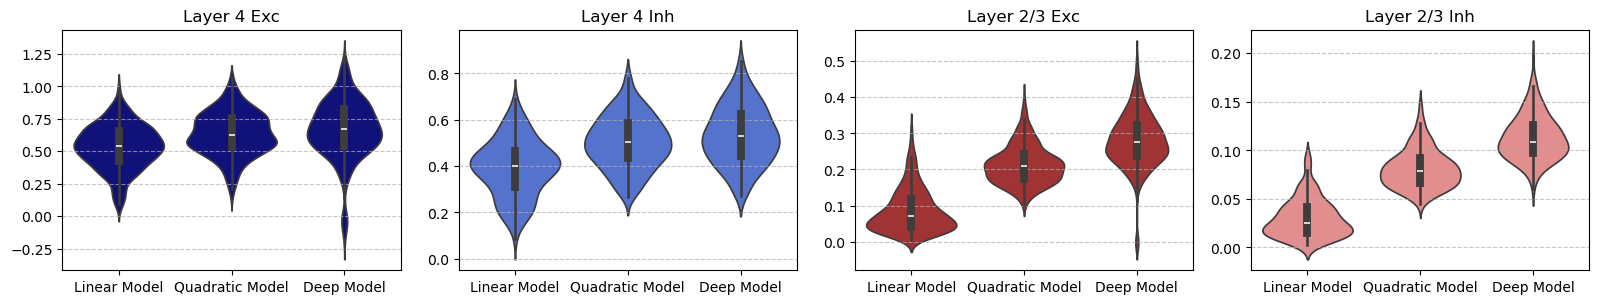

In [119]:
import seaborn as sns
colors = ['darkblue', 'royalblue', 'firebrick', 'lightcoral']
ss(1,4)
plt.subplot(1,4,1)
LL_to_plot = [GLM_LL[L4_exc_idx], GQM_LL[L4_exc_idx], LL3[L4_exc_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.violinplot(data=LL_to_plot, color=colors[0])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 4 Exc')

plt.subplot(1,4,2)
LL_to_plot = [GLM_LL[L4_inh_idx], GQM_LL[L4_inh_idx], LL3[L4_inh_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.violinplot(data=LL_to_plot, color=colors[1])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 4 Inh')

plt.subplot(1,4,3)
LL_to_plot = [GLM_LL[L23_exc_idx], GQM_LL[L23_exc_idx], LL3[L23_exc_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.violinplot(data=LL_to_plot, color=colors[2])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 2/3 Exc')

plt.subplot(1,4,4)
LL_to_plot = [GLM_LL[L23_inh_idx], GQM_LL[L23_inh_idx], LL3[L23_inh_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.violinplot(data=LL_to_plot, color=colors[3])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 2/3 Inh')

Text(0.5, 1.0, 'Layer 2/3 Inh')

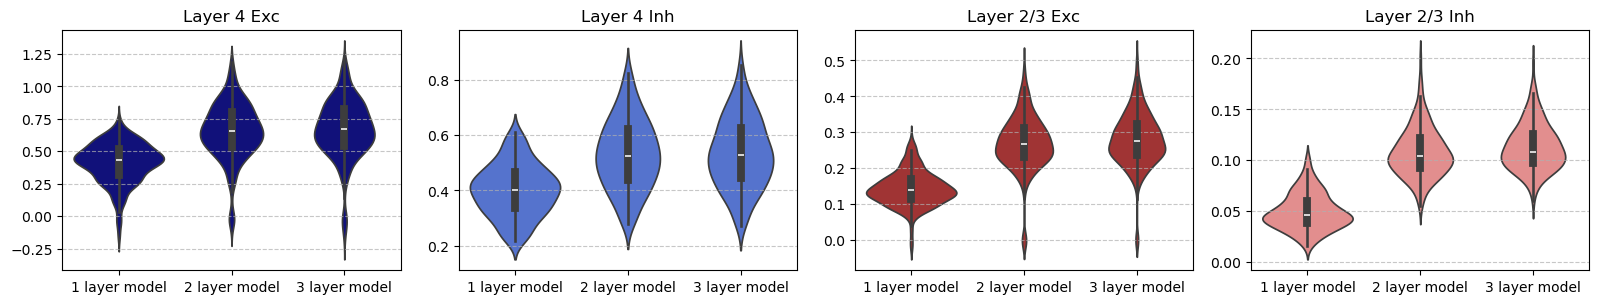

In [120]:
ss(1,4)
plt.subplot(1,4,1)
LL_to_plot = [LL1[L4_exc_idx], LL2[L4_exc_idx], LL3[L4_exc_idx]]
labels = ['1 layer model', '2 layer model', '3 layer model']
sns.violinplot(data=LL_to_plot, color=colors[0])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 4 Exc')

plt.subplot(1,4,2)
LL_to_plot = [LL1[L4_inh_idx], LL2[L4_inh_idx], LL3[L4_inh_idx]]
labels = ['1 layer model', '2 layer model', '3 layer model']
sns.violinplot(data=LL_to_plot, color=colors[1])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 4 Inh')

plt.subplot(1,4,3)
LL_to_plot = [LL1[L23_exc_idx], LL2[L23_exc_idx], LL3[L23_exc_idx]]
labels = ['1 layer model', '2 layer model', '3 layer model']
sns.violinplot(data=LL_to_plot, color=colors[2])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 2/3 Exc')

plt.subplot(1,4,4)
LL_to_plot = [LL1[L23_inh_idx], LL2[L23_inh_idx], LL3[L23_inh_idx]]
labels = ['1 layer model', '2 layer model', '3 layer model']
sns.violinplot(data=LL_to_plot, color=colors[3])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 2/3 Inh')

In [121]:
filters3 = cnn3.get_weights(ffnet_target=0,layer_target=4)
ei_mask_layer3 = deepcopy(cnn3.networks[0].layers[4]._ei_mask).detach().cpu().numpy()
print(filters3.shape)
print(ei_mask_layer3.shape)

(8, 5, 5, 8)
(48,)


In [122]:
# Readout Weights (i.e. Barcodes)
full_ei_mask = np.concatenate((ei_mask_layer1[:filters1.shape[3]], ei_mask_layer2[:filters2.shape[3]], ei_mask_layer3[:filters3.shape[3]]))
readout_w = cnn3.get_weights(ffnet_target=1)
num_filters = [filters1.shape[3], filters2.shape[3], filters3.shape[3]]
print(readout_w.shape)
print(full_ei_mask.shape)

(32, 1491)
(32,)


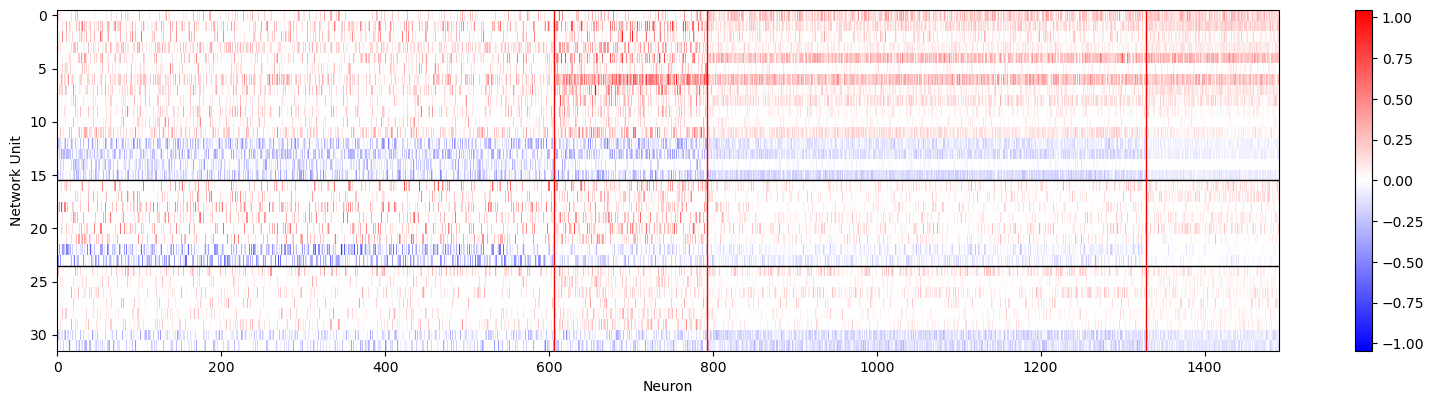

In [123]:
ss(rh=4)
imagesc((readout_w*full_ei_mask.reshape(full_ei_mask.shape[0],1)).T, cmap='bwr')
plt.axhline(y=num_filters[0]-0.5, color='black', lw=1)
plt.axhline(y=sum(num_filters[:2])-0.5, color='black', lw=1)
plt.axvline(x=L4_exc_idx[-1], color='red', lw=1)
plt.axvline(x=L4_inh_idx[-1], color='red', lw=1)
plt.axvline(x=L23_exc_idx[-1], color='red', lw=1)
plt.ylabel('Network Unit')
plt.xlabel('Neuron')
plt.colorbar()

(-0.5, 1490.5, 1490.5, -0.5)

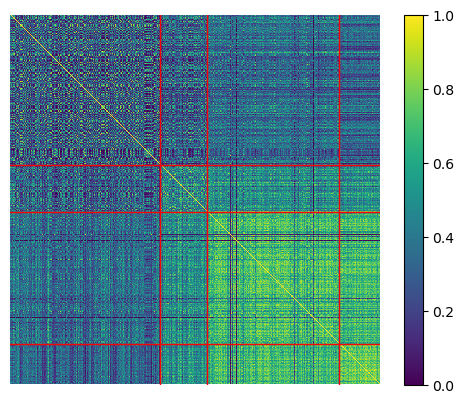

In [124]:
readout_similarity = cos_similarity(readout_w) 

imagesc(readout_similarity)
plt.colorbar()
plt.clim(0,1)
plt.axvline(x=L4_exc_idx[-1], color='red', lw=1)
plt.axhline(y=L4_exc_idx[-1], color='red', lw=1)
plt.axvline(x=L4_inh_idx[-1], color='red', lw=1)
plt.axhline(y=L4_inh_idx[-1], color='red', lw=1)
plt.axvline(x=L23_exc_idx[-1], color='red', lw=1)
plt.axhline(y=L23_exc_idx[-1], color='red', lw=1)
plt.axis('off')

In [125]:
# Connectivity based barcodes set up
level1_exc_idx = list(np.argwhere(ei_mask_layer1[:num_filters[0]]==1)[:,0])
level1_exc_weight_sorted = np.sort(readout_w[:num_filters[0],:][level1_exc_idx,:],axis=0)

level1_inh_idx = list(np.argwhere(ei_mask_layer1[:num_filters[0]]==-1)[:,0])
level1_inh_weight_sorted = np.sort(readout_w[:num_filters[0],:][level1_inh_idx,:],axis=0)

level2_exc_idx = list(np.argwhere(ei_mask_layer2[:num_filters[1]]==1)[:,0])
level2_exc_weight_sorted = np.sort(readout_w[num_filters[0]:sum(num_filters[:2]),:][level2_exc_idx,:],axis=0)

level2_inh_idx = list(np.argwhere(ei_mask_layer2[:num_filters[1]]==-1)[:,0])
level2_inh_weight_sorted = np.sort(readout_w[num_filters[0]:sum(num_filters[:2]),:][level2_inh_idx,:],axis=0)

level3_exc_idx = list(np.argwhere(ei_mask_layer3[:num_filters[2]]==1)[:,0])
level3_exc_weight_sorted = np.sort(readout_w[sum(num_filters[:2]):,:][level3_exc_idx,:],axis=0)

level3_inh_idx = list(np.argwhere(ei_mask_layer3[:num_filters[2]]==-1)[:,0])
level3_inh_weight_sorted = np.sort(readout_w[sum(num_filters[:2]):,:][level3_inh_idx,:],axis=0)

print(level1_exc_weight_sorted.shape)
print(level1_inh_weight_sorted.shape)
print(level2_exc_weight_sorted.shape)
print(level2_inh_weight_sorted.shape)
print(level3_exc_weight_sorted.shape)
print(level3_inh_weight_sorted.shape)

(12, 1491)
(4, 1491)
(6, 1491)
(2, 1491)
(6, 1491)
(2, 1491)


In [126]:
rreadout_w_sorted = np.concatenate([level1_exc_weight_sorted,level1_inh_weight_sorted,level2_exc_weight_sorted,level2_inh_weight_sorted,level3_exc_weight_sorted,level3_inh_weight_sorted], axis=0)
sorted_ei_mask = np.concatenate([np.ones(3*num_filters[0]//4),-1*np.ones(num_filters[0]//4),np.ones(3*num_filters[1]//4),-1*np.ones(num_filters[1]//4),np.ones(3*num_filters[2]//4),-1*np.ones(num_filters[2]//4)], axis=0)
readout_w_sorted.shape

(32, 1491)

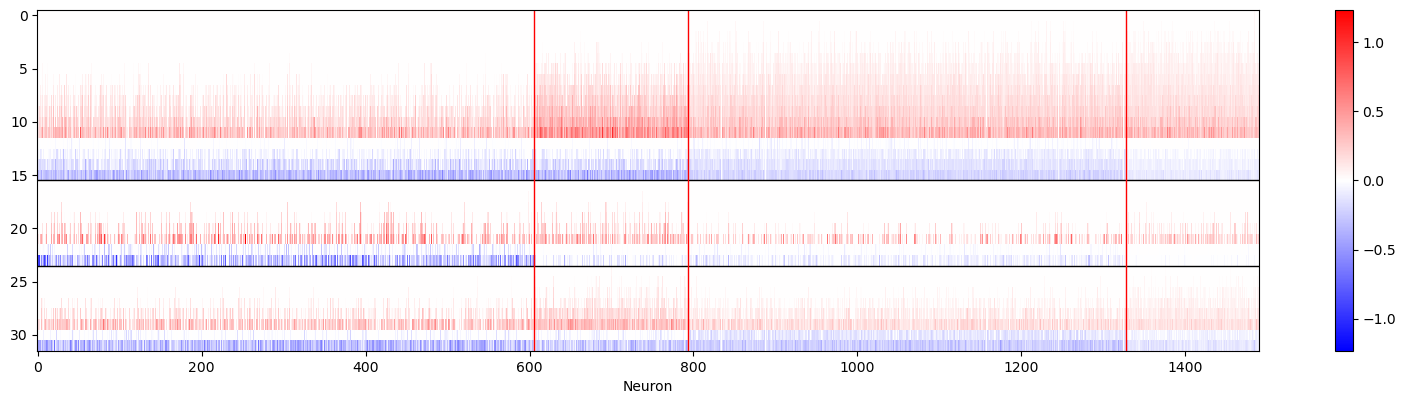

In [127]:
ss(rh=4)
imagesc((readout_w_sorted*sorted_ei_mask.reshape(sorted_ei_mask.shape[0],1)).T, cmap='bwr')
plt.axhline(y=num_filters[0]-0.5, color='black', lw=1)
plt.axhline(y=sum(num_filters[:2])-0.5, color='black', lw=1)
plt.axvline(x=L4_exc_idx[-1], color='red', lw=1)
plt.axvline(x=L4_inh_idx[-1], color='red', lw=1)
plt.axvline(x=L23_exc_idx[-1], color='red', lw=1)
plt.xlabel('Neuron')
plt.colorbar()

(-0.5, 1490.5, 1490.5, -0.5)

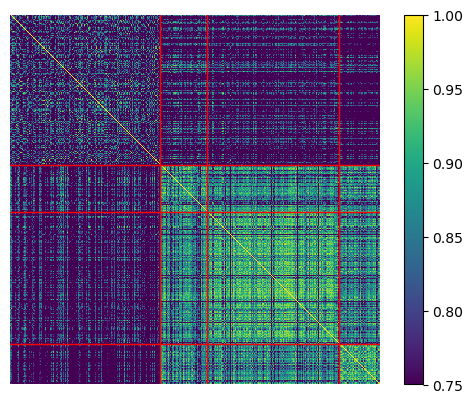

In [128]:
sorted_readout_similarity = cos_similarity(readout_w_sorted)

imagesc(sorted_readout_similarity)
plt.colorbar()
plt.clim(0.75,1)
plt.axvline(x=L4_exc_idx[-1], color='red', lw=1)
plt.axhline(y=L4_exc_idx[-1], color='red', lw=1)
plt.axvline(x=L4_inh_idx[-1], color='red', lw=1)
plt.axhline(y=L4_inh_idx[-1], color='red', lw=1)
plt.axvline(x=L23_exc_idx[-1], color='red', lw=1)
plt.axhline(y=L23_exc_idx[-1], color='red', lw=1)
plt.axis('off')

## Train Full CNN

In [129]:
full_cnn = NDN(ffnet_list = [scaffold_netQ, readout_netQ], loss_type='poisson')
print(full_cnn.info())
print(full_cnn.list_parameters())

NDN poisson, output net #1:
  0 scaffold3d: Input = 'stim' [1, 60, 60, 1], Scaffold levels = 1 3 4
    0 STconv10:   2 (i0)  [relu] w19 NBH	{'d2xt': 0.0001, 'd2x': 1.0, 'center': 0.05}
    1  oriconv:  16 (i4)  [relu] w19 NBH	{'d2x': 0.003, 'center': 0.0001}
    2   normal:   1 (i0)  [lin]   		
    3  oriconv:   8 (i2)  [relu] w5  NB		
    4  oriconv:   8 (i2)  [relu] w5  NB		
  1 readout: Input = ffnet 0 [32, 60, 60, 6]
    0 readQsmp: 1491 (i0)  [soft]  bias+	{'max': 0.0001}
None
Network 0:
  Layer 0:
      weight: torch.Size([3610, 2])
  Layer 1:
      weight: torch.Size([722, 16])
  Layer 2:
      NOT FIT: weight: torch.Size([1, 1])
  Layer 3:
      weight: torch.Size([400, 8])
  Layer 4:
      weight: torch.Size([200, 8])
Network 1:
  Layer 0:
      weight: torch.Size([32, 1491])
      bias: torch.Size([1491])
      mu: torch.Size([1491, 2])
      sigma: torch.Size([1491, 1])
      Qmu: torch.Size([1491, 1])
      Qsigma: torch.Size([1491, 1])
None


In [130]:
# Network 0: fix LGN filters
full_cnn.networks[0].layers[0].weight.data = deepcopy(LGN_cnn.networks[0].layers[0].weight.data)
full_cnn.networks[0].layers[0].set_parameters(val=False)
# Network 0: projection filters
full_cnn.networks[0].layers[1].weight.data = deepcopy(cnn1.networks[0].layers[1].weight.data)
full_cnn.networks[0].layers[1].set_parameters(val=True)
# Network 0: second filters
full_cnn.networks[0].layers[3].weight.data = deepcopy(cnn2.networks[0].layers[3].weight.data)
full_cnn.networks[0].layers[3].set_parameters(val=True)
# Network 0: third filters
full_cnn.networks[0].layers[4].weight.data = deepcopy(cnn3.networks[0].layers[4].weight.data)
full_cnn.networks[0].layers[4].set_parameters(val=True)
# Network 1: set mu values
full_cnn.networks[1].layers[0].mu.data = torch.tensor(mu0s, dtype=torch.float32)
full_cnn.networks[1].layers[0].Qmu.data[:,0] = torch.tensor(Qmu0s, dtype=torch.float32)
full_cnn.networks[1].layers[0].fit_mus(True)
full_cnn.networks[1].layers[0].fit_Qmus(False)
full_cnn.networks[1].layers[0].Qsample_mode = angle_mode
full_cnn.block_sample = True

  ReadoutLayer: fitting mus
  ReadoutLayer: not fitting Qmus


In [131]:
full_cnn.fit(data, **adam_pars, verbose=2)

Model: M491_CsXXXX_X

GPU Available: True, GPU Used: True


Validating ver=130: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 102/102 [00:22<00:00,  4.62it/s, val_loss=0.286894]

Early stopping
Done fitting
  Fit complete: 6579.813041210175 sec elapsed


In [132]:
LL_full = full_cnn.eval_models(data, data_inds=data.val_blks, device=device, batch_size=1, null_adjusted=True)
print('Log Likelyhood shape', LL_full.shape)

Eval models: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 102/102 [00:21<00:00,  4.71it/s]

Log Likelyhood shape (1491,)


In [133]:
print('L4 Exc Mean LL:', np.mean(LL_full[L4_exc_idx]), 'L4 Inh Mean LL:', np.mean(LL_full[L4_inh_idx]),
      'L2/3 Exc Mean LL:', np.mean(LL_full[L23_exc_idx]), 'L2/3 Inh Mean LL:', np.mean(LL_full[L23_inh_idx]))

L4 Exc Mean LL: 0.69753814 L4 Inh Mean LL: 0.55836624 L2/3 Exc Mean LL: 0.29471356 L2/3 Inh Mean LL: 0.11534524


Text(0.5, 1.0, 'Layer 2/3 Inh')

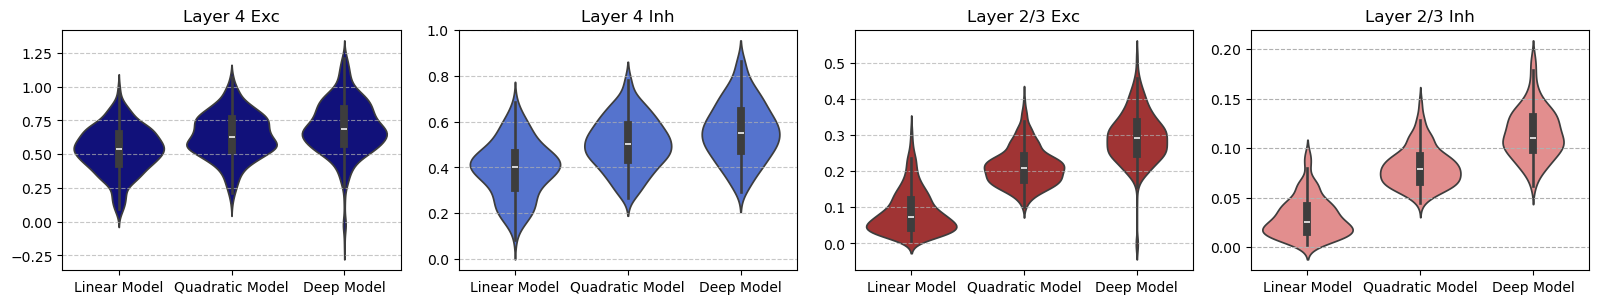

In [136]:
ss(1,4)
plt.subplot(1,4,1)
LL_to_plot = [GLM_LL[L4_exc_idx], GQM_LL[L4_exc_idx], LL_full[L4_exc_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.violinplot(data=LL_to_plot, color=colors[0])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 4 Exc')

plt.subplot(1,4,2)
LL_to_plot = [GLM_LL[L4_inh_idx], GQM_LL[L4_inh_idx], LL_full[L4_inh_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.violinplot(data=LL_to_plot, color=colors[1])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 4 Inh')

plt.subplot(1,4,3)
LL_to_plot = [GLM_LL[L23_exc_idx], GQM_LL[L23_exc_idx], LL_full[L23_exc_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.violinplot(data=LL_to_plot, color=colors[2])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 2/3 Exc')

plt.subplot(1,4,4)
LL_to_plot = [GLM_LL[L23_inh_idx], GQM_LL[L23_inh_idx], LL_full[L23_inh_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.violinplot(data=LL_to_plot, color=colors[3])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--')
plt.title('Layer 2/3 Inh')

Text(0.5, 1.0, 'Layer 2/3 Inh')

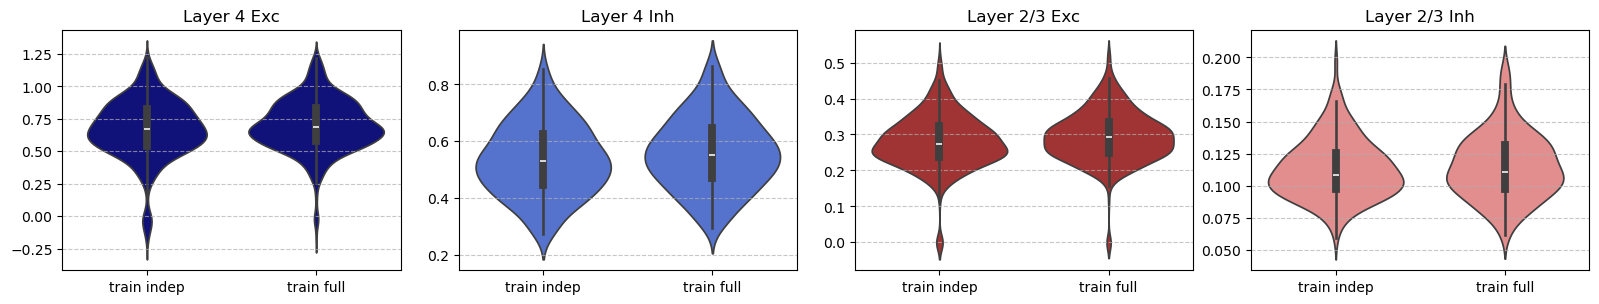

In [134]:
ss(1,4)
plt.subplot(1,4,1)
LL_to_plot = [LL3[L4_exc_idx], LL_full[L4_exc_idx]]
labels = ['train indep', 'train full']
sns.violinplot(data=LL_to_plot, color=colors[0])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 4 Exc')

plt.subplot(1,4,2)
LL_to_plot = [LL3[L4_inh_idx], LL_full[L4_inh_idx]]
labels = ['train indep', 'train full']
sns.violinplot(data=LL_to_plot, color=colors[1])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 4 Inh')

plt.subplot(1,4,3)
LL_to_plot = [LL3[L23_exc_idx], LL_full[L23_exc_idx]]
labels = ['train indep', 'train full']
sns.violinplot(data=LL_to_plot, color=colors[2])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 2/3 Exc')

plt.subplot(1,4,4)
LL_to_plot = [LL3[L23_inh_idx], LL_full[L23_inh_idx]]
labels = ['train indep', 'train full']
sns.violinplot(data=LL_to_plot, color=colors[3])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 2/3 Inh')

In [137]:
filters1 = full_cnn.get_weights(ffnet_target=0,layer_target=1)
filters2 = full_cnn.get_weights(ffnet_target=0,layer_target=3)
filters3 = full_cnn.get_weights(ffnet_target=0,layer_target=4)
ei_mask_layer1 = deepcopy(full_cnn.networks[0].layers[1]._ei_mask).detach().cpu().numpy()
ei_mask_layer2 = deepcopy(full_cnn.networks[0].layers[3]._ei_mask).detach().cpu().numpy()
ei_mask_layer3 = deepcopy(full_cnn.networks[0].layers[4]._ei_mask).detach().cpu().numpy()
num_filters = [filters1.shape[3], filters2.shape[3], filters3.shape[3]]
print(filters1.shape)
print(filters2.shape)
print(filters3.shape)
print(ei_mask_layer1.shape)
print(ei_mask_layer2.shape)
print(ei_mask_layer3.shape)
print(num_filters)

(2, 19, 19, 16)
(16, 5, 5, 8)
(8, 5, 5, 8)
(96,)
(48,)
(48,)
[16, 8, 8]


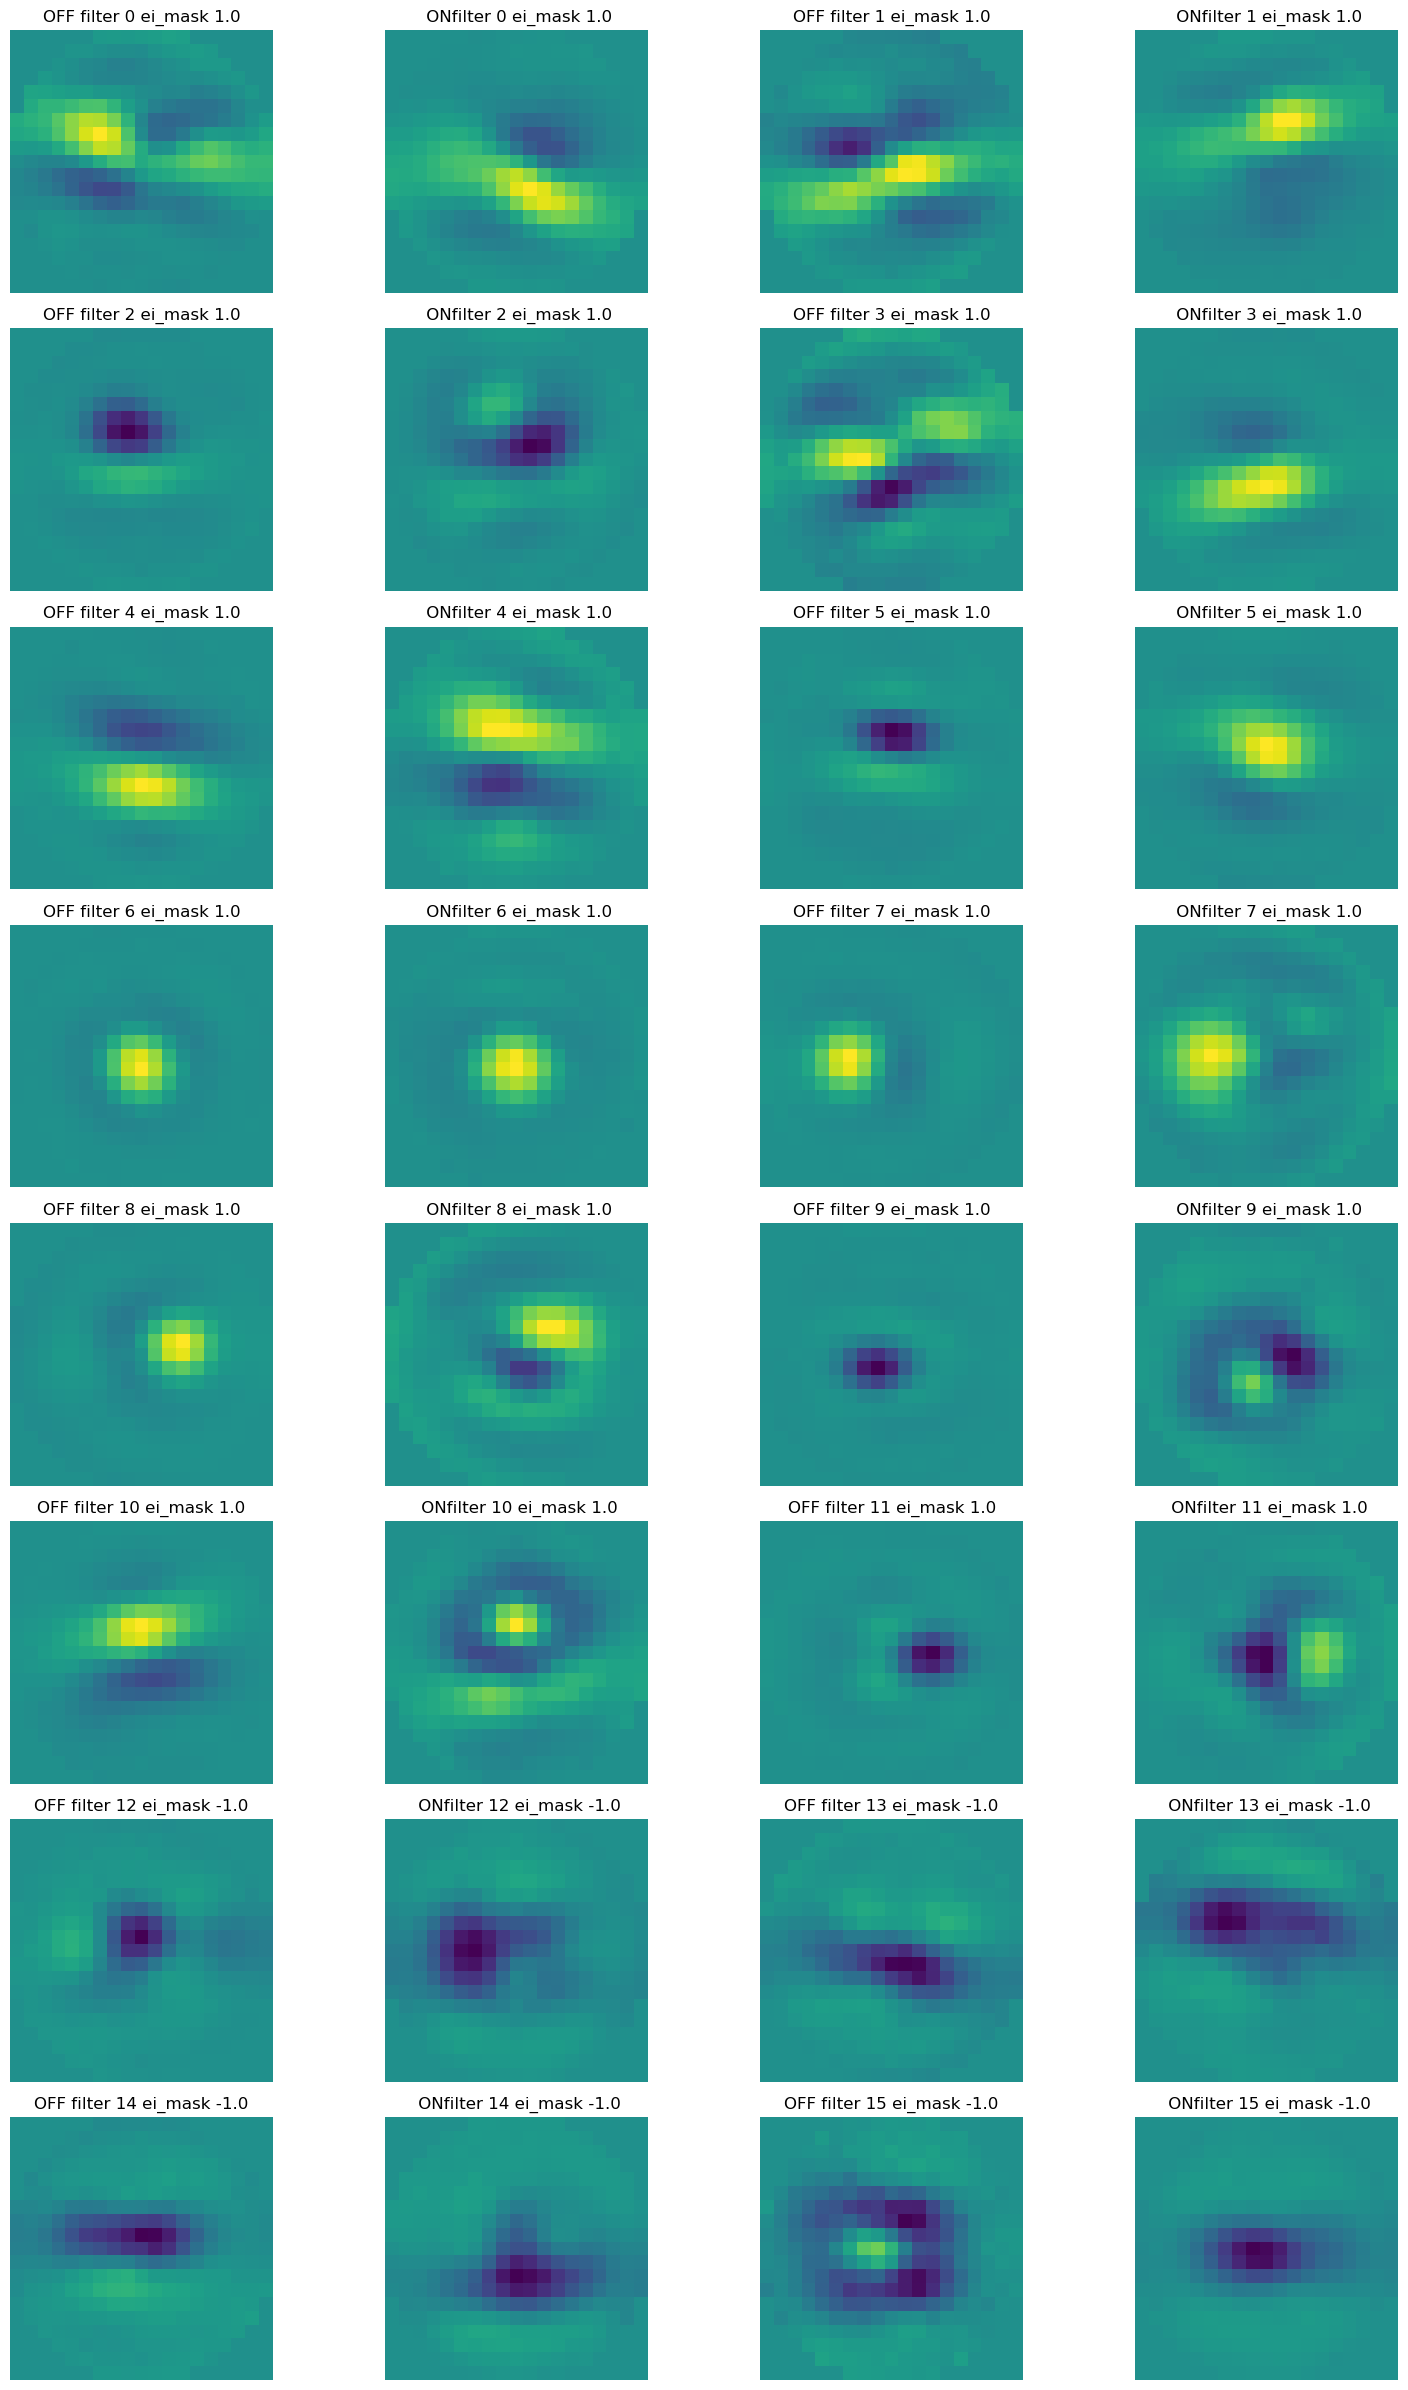

In [138]:
ss(8,4)
k = 1
for i in range(16):
    plt.subplot(8,4,k)
    imagesc(filters1[0,:,:,i], balanced=True)
    plt.title('OFF filter '+str(i)+' ei_mask '+str(ei_mask_layer1[i]))
    plt.axis('off')
    k += 1

    plt.subplot(8,4,k)
    imagesc(filters1[1,:,:,i], balanced=True)
    plt.title(' ONfilter '+str(i)+' ei_mask '+str(ei_mask_layer1[i]))
    plt.axis('off')
    k += 1
plt.tight_layout()
plt.show()